In [106]:
import pandas as pd
import numpy as np
import cv2 as cv
import os
from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV
import time
import six
from IPython.display import Image

from functions_dl import *

---
# 1. Import des donnnées

In [2]:
dogs = pd.read_csv('src/dogs.csv')
dogs

,uri,breeds
0,src\img\n02085620-Chihuahua\n02085620_10074.jpg,Chihuahua
1,src\img\n02085620-Chihuahua\n02085620_10131.jpg,Chihuahua
2,src\img\n02085620-Chihuahua\n02085620_10621.jpg,Chihuahua
3,src\img\n02085620-Chihuahua\n02085620_1073.jpg,Chihuahua
4,src\img\n02085620-Chihuahua\n02085620_10976.jpg,Chihuahua
...,...,...
20574,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20575,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20576,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog
20577,src\img\n02116738-African_hunting_dog\n0211673...,African_hunting_dog


In [3]:
print(f'Nous avons {len(dogs)} photos de chiens comprenant {dogs.breeds.nunique()} races.')

Nous avons 20579 photos de chiens comprenant 120 races.


In [4]:
top5breeds = dogs.groupby('breeds').count().sort_values(by='uri', ascending=False).head().reset_index().breeds.to_list()
top5breeds

[&#39;Maltese_dog&#39;, &#39;Afghan_hound&#39;, &#39;Scottish_deerhound&#39;, &#39;Pomeranian&#39;, &#39;Samoyed&#39;]

In [5]:
dogs5 = pd.DataFrame()
for b in top5breeds:
    dogs5 = dogs5.append(dogs[dogs.breeds == b])

dogs5

,uri,breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog
...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed


In [79]:
le = LabelEncoder()
dogs5['encoding_breeds'] = le.fit_transform(dogs5.breeds)
dogs5

,uri,breeds,encoding_breeds
337,src\img\n02085936-Maltese_dog\n02085936_10073.jpg,Maltese_dog,1
338,src\img\n02085936-Maltese_dog\n02085936_10130.jpg,Maltese_dog,1
339,src\img\n02085936-Maltese_dog\n02085936_10148.jpg,Maltese_dog,1
340,src\img\n02085936-Maltese_dog\n02085936_10197.jpg,Maltese_dog,1
341,src\img\n02085936-Maltese_dog\n02085936_10199.jpg,Maltese_dog,1
...,...,...,...
18417,src\img\n02111889-Samoyed\n02111889_899.jpg,Samoyed,3
18418,src\img\n02111889-Samoyed\n02111889_9001.jpg,Samoyed,3
18419,src\img\n02111889-Samoyed\n02111889_91.jpg,Samoyed,3
18420,src\img\n02111889-Samoyed\n02111889_928.jpg,Samoyed,3


---
# 2. Test SIFT

In [80]:
X_train, X_test, y_train, y_test = train_test_split(dogs5.uri, dogs5.encoding_breeds, test_size=0.2, random_state=42)

In [7]:
%time sifts = get_sifts_features(X_train)

Wall time: 9min 30s


In [8]:
descriptor_list = sifts[0] 
train_bovw_features = sifts[1]
print(f"Nous avons {len(descriptor_list)} descripteurs dans le jeu d'entrainement ({len(X_train)} photos)")

Nous avons 589022 descripteurs dans le jeu d&#39;entrainement (928 photos)


In [9]:
%time test_bovw_features = get_sifts_features(X_test)[1] 

Wall time: 2min 41s


In [10]:
batch_size = int(len(descriptor_list) * 0.1)
batch_size

58902

100
200
300
400
500
600
700
800
900


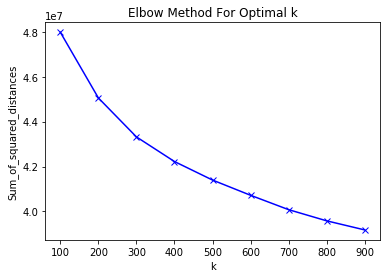

In [11]:
# Méthode visuelle
Sum_of_squared_distances = []
K = np.arange(100, 1000, 100)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
    km = km.fit(descriptor_list)
    Sum_of_squared_distances.append(km.inertia_)

plt.clf()
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.savefig('img/img_elbow_kmeans.png',
            transparent=True)

In [13]:
k = 300
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
%time kmeans.fit(descriptor_list)

Wall time: 2min


MiniBatchKMeans(batch_size=58902, compute_labels=True, init=&#39;k-means++&#39;,
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=300, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [89]:
%time bovw_train = get_predict_sift(X_train, kmeans, k)
bovw_train

Wall time: 9min 26s


In [68]:
%time bovw_test = get_predict_sift(X_test, kmeans, k)
bovw_test

Wall time: 2min 48s


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.0,1.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,3.0,...,0.0,1.0,4.0,0.0,2.0,2.0,3.0,4.0,0.0,3.0
1,1.0,9.0,0.0,1.0,2.0,0.0,0.0,24.0,1.0,0.0,...,0.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0
2,3.0,6.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,3.0,...,2.0,3.0,0.0,2.0,0.0,3.0,4.0,6.0,3.0,2.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
4,2.0,7.0,1.0,0.0,2.0,0.0,0.0,1.0,3.0,0.0,...,1.0,2.0,0.0,2.0,3.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
228,0.0,3.0,7.0,1.0,2.0,0.0,8.0,1.0,4.0,0.0,...,2.0,0.0,5.0,1.0,5.0,0.0,0.0,1.0,3.0,2.0
229,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
230,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Classification

LogisticRegression en cours d&#39;exécution...
LinearSVC en cours d&#39;exécution...
SGD en cours d&#39;exécution...


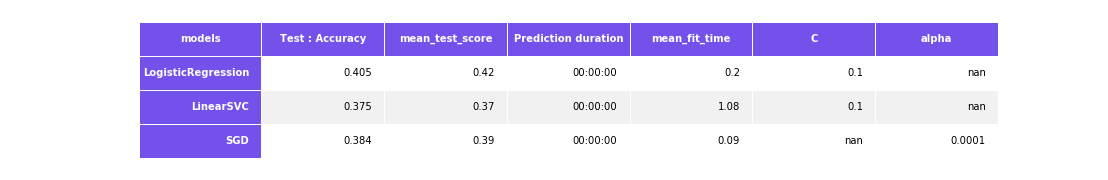

Wall time: 4.06 s


In [112]:
# To Do : Tester Random Forest et Gradient boosting
classifiers = [('LogisticRegression',
                LogisticRegression(),
                [{'C': [0.1, 1]}]),

              ('LinearSVC',
               LinearSVC(),
               [{'C': [00.1, 0.1, 1]}]), 

              ('SGD',
               SGDClassifier(),
               [{'alpha': [10**-6, 10**-5, 10**-4]}])]

%time evaluate_classifier(bovw_train, bovw_test, y_train, y_test, classifiers, cv=5)